<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

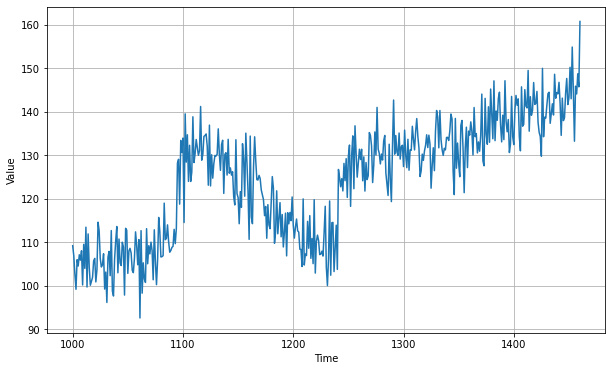

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)


Metal device set to: Apple M1 Pro
Epoch 1/100


2022-03-21 17:59:13.009199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 17:59:13.009322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-21 17:59:13.154531: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


     30/Unknown - 0s 4ms/step - loss: 567.8786 

2022-03-21 17:59:13.275327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 10ms/step - loss: 558.6163
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 65.4717
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 51.0639
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 50.5668
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 49.8937
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 49.3748
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 48.5091
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 48.4986
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 47.6357
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 47.0038
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 47.1232
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 46.1082
Epoch 13/100
31/31 [===============

2022-03-21 17:59:30.087832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


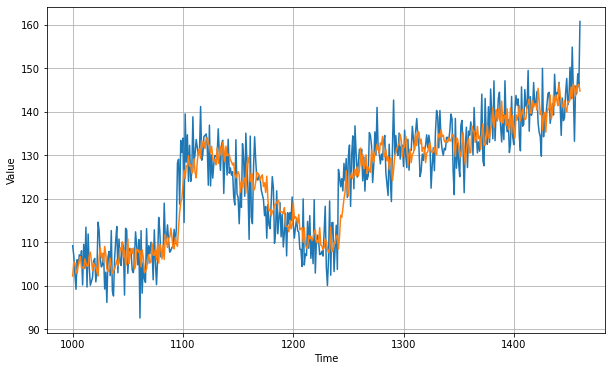

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7166286

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

2022-03-21 17:59:59.803115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(1e-08, 0.001, 0.0, 300.0)

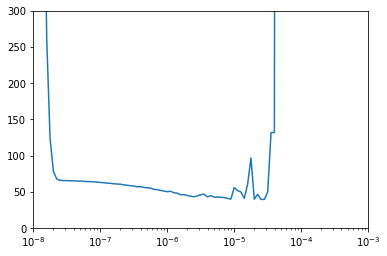

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [12]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

2022-03-21 18:00:15.261668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


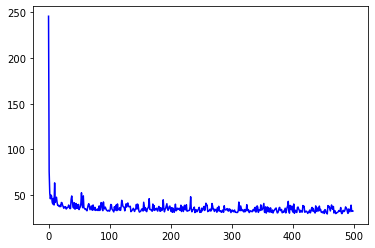

In [13]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[63.522735595703125, 42.119606018066406, 46.760826110839844, 47.831626892089844, 42.14724349975586, 38.92369079589844, 39.017066955566406, 38.073917388916016, 37.578983306884766, 39.049171447753906, 37.53526306152344, 42.094058990478516, 41.87014389038086, 39.292667388916016, 37.410179138183594, 35.773372650146484, 37.19646072387695, 36.58298110961914, 37.432579040527344, 34.97174072265625, 36.001983642578125, 36.34135055541992, 37.17653274536133, 39.31620407104492, 37.27088928222656, 35.50557327270508, 35.472103118896484, 45.451316833496094, 49.230560302734375, 43.26239013671875, 37.69382858276367, 36.02568435668945, 41.86878967285156, 34.95773696899414, 35.03105163574219, 41.07221603393555, 35.813533782958984, 39.47666931152344, 35.666465759277344, 39.97685623168945, 34.34378433227539, 36.051124572753906, 37.20519256591797, 41.19110870361328, 52.73142623901367, 39.499053955078125, 36.390594482421875, 49.31745529174805, 36.334163665771484, 35.654781341552734, 34.56877899169922, 35.010

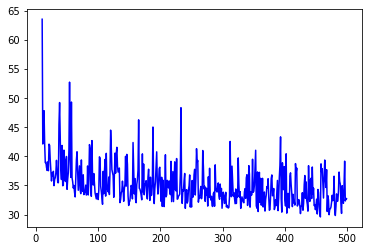

In [14]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

2022-03-21 18:04:41.599308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


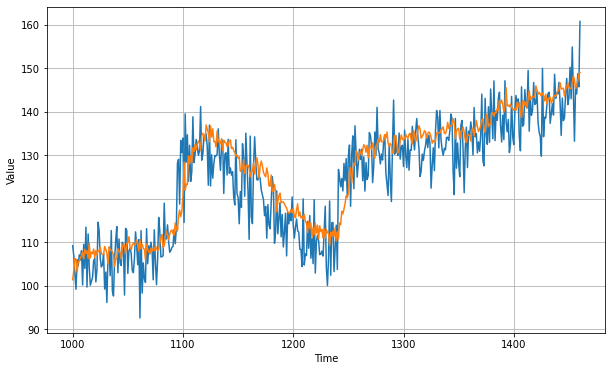

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1452713